<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Set-Parameter" data-toc-modified-id="Set-Parameter-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Set Parameter</a></span></li><li><span><a href="#Load-Energy-Overall-Data" data-toc-modified-id="Load-Energy-Overall-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Energy Overall Data</a></span></li><li><span><a href="#Select-Universe-Based-On-Using-Quantile-Using-ESG-Score" data-toc-modified-id="Select-Universe-Based-On-Using-Quantile-Using-ESG-Score-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Select Universe Based On Using Quantile Using ESG Score</a></span></li><li><span><a href="#Download-Portfolio-Data" data-toc-modified-id="Download-Portfolio-Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Download Portfolio Data</a></span></li><li><span><a href="#Use-Historical-Approach-To-Calculate-VaR" data-toc-modified-id="Use-Historical-Approach-To-Calculate-VaR-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Use Historical Approach To Calculate VaR</a></span><ul class="toc-item"><li><span><a href="#Define-A-Function" data-toc-modified-id="Define-A-Function-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Define A Function</a></span></li><li><span><a href="#Calculate-Top" data-toc-modified-id="Calculate-Top-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Calculate Top</a></span></li><li><span><a href="#Calculate-Bottom" data-toc-modified-id="Calculate-Bottom-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Calculate Bottom</a></span></li><li><span><a href="#Top-VS-Bottom:-Portfolio-Value" data-toc-modified-id="Top-VS-Bottom:-Portfolio-Value-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Top VS Bottom: Portfolio Value</a></span></li><li><span><a href="#Top-VS-Bottom:-Portfolio-VaR" data-toc-modified-id="Top-VS-Bottom:-Portfolio-VaR-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Top VS Bottom: Portfolio VaR</a></span></li></ul></li><li><span><a href="#Use-DNN" data-toc-modified-id="Use-DNN-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Use DNN</a></span><ul class="toc-item"><li><span><a href="#Define-A-Function" data-toc-modified-id="Define-A-Function-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Define A Function</a></span></li><li><span><a href="#Calculate-Top" data-toc-modified-id="Calculate-Top-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Calculate Top</a></span></li><li><span><a href="#Calculate-Bottom" data-toc-modified-id="Calculate-Bottom-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Calculate Bottom</a></span></li><li><span><a href="#Top-Vs-Bottom-VaR" data-toc-modified-id="Top-Vs-Bottom-VaR-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Top Vs Bottom VaR</a></span></li></ul></li><li><span><a href="#Load-Green-Predictor-Data" data-toc-modified-id="Load-Green-Predictor-Data-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Load Green Predictor Data</a></span></li><li><span><a href="#Use-DNN-+-Green-Predictor" data-toc-modified-id="Use-DNN-+-Green-Predictor-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Use DNN + Green Predictor</a></span></li><li><span><a href="#Use-LSTM" data-toc-modified-id="Use-LSTM-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Use LSTM</a></span></li></ul></div>

## Load Package

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import math
import yfinance as yf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from datetime import datetime, timedelta
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

## Set Parameter

In [2]:
# set parameters
stock_start_date = "2015-01-01"
stock_end_date = "2019-01-01"
VaR_q = 0.05

## Download Portfolio Data

In [3]:
# download stock data
ticker = ['TSLA']
start_date = stock_start_date
end_date = stock_end_date

top_price = yf.download(ticker,
                        start = start_date,
                        end = end_date)


[*********************100%***********************]  1 of 1 completed


In [4]:
# choose the adjust price to analyze
#top_price = top_price[["Adj Close", "Volume"]]
top_price = top_price["Adj Close"]

In [5]:
top_price

Date
2015-01-02    14.620667
2015-01-05    14.006000
2015-01-06    14.085333
2015-01-07    14.063333
2015-01-08    14.041333
                ...    
2018-12-24    19.692667
2018-12-26    21.739332
2018-12-27    21.075333
2018-12-28    22.257999
2018-12-31    22.186666
Name: Adj Close, Length: 1006, dtype: float64

In [6]:
# calculate daily log return
# volume = top_price.iloc[1:, 1]
top_ret = np.log(top_price) - np.log(top_price.shift(1))

top_ret.dropna(axis = 0, inplace = True)
# top_ret['Volume'] = volume

In [7]:
top_ret

Date
2015-01-05   -0.042950
2015-01-06    0.005648
2015-01-07   -0.001563
2015-01-08   -0.001566
2015-01-09   -0.018981
                ...   
2018-12-24   -0.079305
2018-12-26    0.098877
2018-12-27   -0.031020
2018-12-28    0.054598
2018-12-31   -0.003210
Name: Adj Close, Length: 1005, dtype: float64

## Use Historical Approach To Calculate VaR

### Define A Function

In [8]:
# define a function to get 95%-VaR for equal weighted portfolio (i.e. invest 100 to each stock)
def get_VaR(ret, q):
    T = 252*3
    num_return = len(ret)
    #num_asset = len(ret.columns)
    # num_asset = 1
    #investment_money = 100*num_asset
    investment_money = 1
    VaR_hist = np.zeros(num_return - T)
    actual_ret = np.zeros(num_return - T)
    
    for t in range(T, num_return):
        #w = 1/num_asset
        
        #scenario_port_ret_t = ret.iloc[t-T:t, :] * w
        scenario_port_ret_t = ret[t-T:t]
        #scenario_port_ret_t = scenario_port_ret_t.sum(axis = 1)
        scenario_port_val_t = investment_money * scenario_port_ret_t
        VaR_hist[t-T] = -np.quantile(scenario_port_val_t, q = q)
        
        #actual_ret[t-T] = investment_money*((ret.iloc[t,:] * w).sum())
        actual_ret[t-T] = investment_money * ret[t]
        
    return VaR_hist, actual_ret

In [9]:
VaR_hist_top, actual_ret_top = get_VaR(top_ret, VaR_q)

In [10]:
VaR_hist_top.shape

(249,)

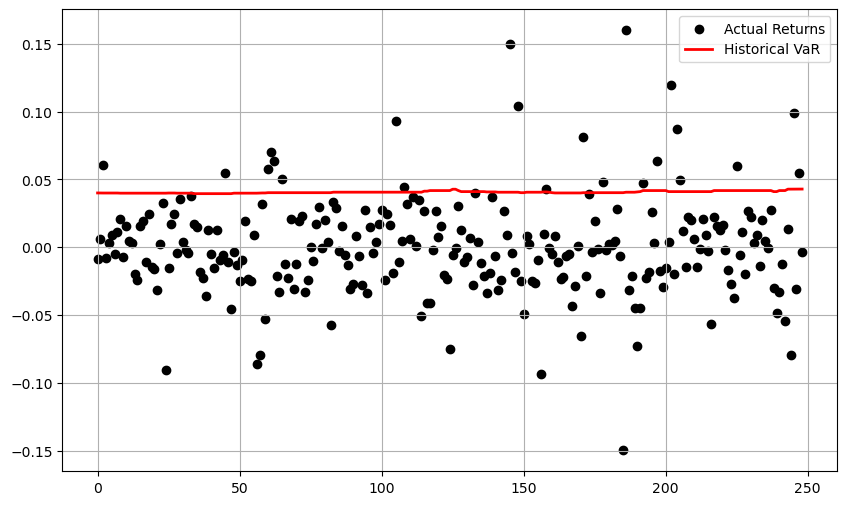

In [11]:
plt.figure(figsize=(10,6))
plt.scatter(range(len(actual_ret_top)) , actual_ret_top , 
            color='k',
            label = "Actual Returns")
plt.plot(range(len(VaR_hist_top)) , VaR_hist_top , 
         color='r', 
         linewidth=2,
         label = "Historical VaR")

plt.legend()
plt.grid()
plt.show()

In [12]:
# Empirically loss exceed our 95% VaR some of the time:
np.mean(-actual_ret_top > VaR_hist_top)

0.08433734939759036

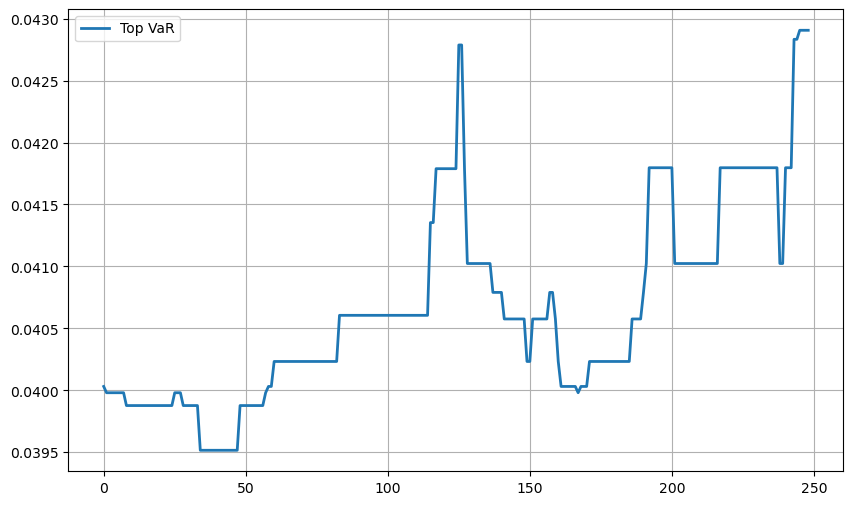

In [13]:
plt.figure(figsize=(10,6))
plt.plot(range(len(VaR_hist_top)), VaR_hist_top,
         label = "Top VaR",
         linewidth=2)

plt.legend()
plt.grid()
plt.show()

## Regression Trees: Boosting (to complete)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [ ]:
def train_VaR_boost(ret, quantile, n, lr, d):
    
    T = 252*3
    num_return = len(ret)
    num_asset = len(ret.columns)
    investment_money = 100*num_asset
    VaR_boost = np.zeros(num_return - T)
    
    # build neural network 
    gbr_quantile = GradientBoostingRegressor(loss='quantile', alpha=quantile,
                                         n_estimators=n, learning_rate=lr, max_depth=d, random_state=42)
    
    
    # train neural network
    for t in range(T, num_return):

        w = 1/num_asset
        
        scenario_port_ret_t = ret.iloc[t-T:t, :] * w
        scenario_port_ret_t = scenario_port_ret_t.sum(axis = 1)

        x_t = ret.iloc[t-T:t-1, :].to_numpy()
        y_t = scenario_port_ret_t.iloc[1:T].to_numpy()
        
        gbr_quantile.fit(x_t, y_t)
        
        ret_t = ret.iloc[t-1, :].to_numpy()
        ret_t = ret_t.reshape(1, -1)
        
        VaR_boost[t-T] = investment_money*gbr_quantile.predict(ret_t)
        
    return VaR_boost

In [ ]:
VaR_boost_top = train_VaR_boost(top_ret, VaR_q, 100, 0.1, 5)

In [ ]:
### try for hyperparameter tuning 
learning_rate = [0.1, 0.01]
num_estimators = [100, 500]
depth = [ 3, 5, 7]
back_test = []
for lr in learning_rate:
    for n in num_estimators:
        for d in depth:
            VaR_boost_top = train_VaR_boost(top_ret, VaR_q, n, lr, d)
            back_test.append([n, lr, d, np.mean( actual_ret_top < VaR_boost_top)])

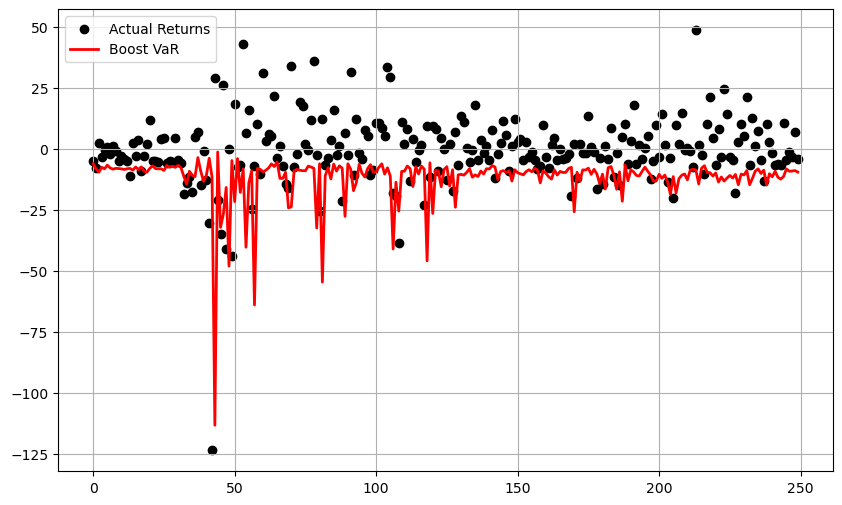

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(range(len(actual_ret_top)) , actual_ret_top , 
            color='k',
            label = "Actual Returns")

plt.plot(range(len(VaR_boost_top)) , VaR_boost_top , 
         color='r',
         linewidth=2,
         label = "Boost VaR")

plt.legend()
plt.grid()
plt.show()

In [ ]:
np.mean( actual_ret_top < VaR_boost_top)

0.164

## QARNN (cambiare nome)

In [14]:
ticker = ['TSLA']
start_date = datetime.strptime(stock_start_date, "%Y-%m-%d") - timedelta(days=22)
end_date = stock_end_date

top_price = yf.download(ticker,
                        start = start_date,
                        end = end_date)

[*********************100%***********************]  1 of 1 completed


In [15]:
top_ret = np.log(top_price['Adj Close']) - np.log(top_price['Adj Close'].shift(1))
top_volume_ret = np.log(top_price['Volume']) - np.log(top_price['Volume'].shift(1))
sd_3 = top_ret.rolling(window=3).std()
sd_7 = top_ret.rolling(window=7).std()
sd_15 = top_ret.rolling(window=15).std()

In [16]:
df = pd.DataFrame({
    'returns': top_ret,
    'returns_1': top_ret.shift(1),
    'returns_2': top_ret.shift(2),
    'returns_3': top_ret.shift(3),
    'vol_1': top_volume_ret.shift(1),
    'vol_2': top_volume_ret.shift(2),
    'vol_3': top_volume_ret.shift(3),
    'sd_3': sd_3.shift(1),
    'sd_7': sd_7.shift(1),
    'sd_15': sd_15.shift(1),
})

df = df.dropna()
df_train = df.loc['2015-01-01':'2017-12-31']
df_test = df.loc['2018-01-01':'2019-01-01']
# Visualizza il DataFrame risultante
print(df_train)

             returns  returns_1  returns_2  returns_3     vol_1     vol_2  \
Date                                                                        
2015-01-05 -0.042950  -0.014036   0.000810  -0.015538  0.729350 -0.233992   
2015-01-06  0.005648  -0.042950  -0.014036   0.000810  0.119377  0.729350   
2015-01-07 -0.001563   0.005648  -0.042950  -0.014036  0.153935  0.119377   
2015-01-08 -0.001566  -0.001563   0.005648  -0.042950 -0.746461  0.153935   
2015-01-09 -0.018981  -0.001566  -0.001563   0.005648  0.148175 -0.746461   
...              ...        ...        ...        ...       ...       ...   
2017-12-22 -0.019670   0.008113  -0.006424  -0.023196 -0.305794 -0.136563   
2017-12-26 -0.024624  -0.019670   0.008113  -0.006424 -0.039396 -0.305794   
2017-12-27 -0.017968  -0.024624  -0.019670   0.008113  0.037844 -0.039396   
2017-12-28  0.011866  -0.017968  -0.024624  -0.019670  0.073450  0.037844   
2017-12-29 -0.012797   0.011866  -0.017968  -0.024624 -0.087735  0.073450   

C:\Users\lausiell\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


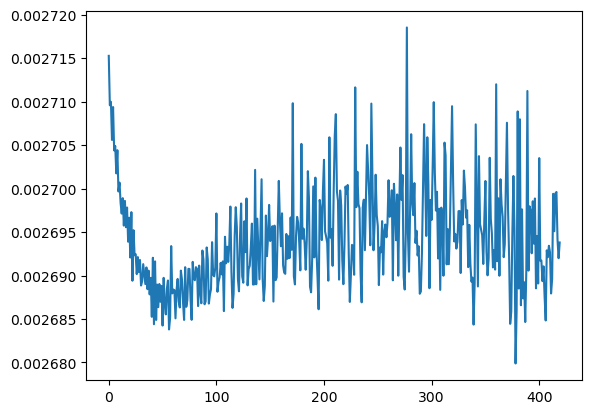

[0.8171274065971375, 0.7492911219596863, 0.6818469762802124, 0.6147433519363403, 0.5479444265365601, 0.48142009973526, 0.4151451587677002, 0.34909671545028687, 0.28325513005256653, 0.21760207414627075, 0.15224508941173553, 0.08919202536344528, 0.04064140096306801, 0.01786074973642826, 0.010471305809915066, 0.007696580607444048, 0.00647012097761035, 0.005833542440086603, 0.0055131190456449986, 0.005338161718100309, 0.005201190710067749, 0.005097914021462202, 0.005011136643588543, 0.004931895527988672, 0.004853710066527128, 0.00477447547018528, 0.004698778502643108, 0.0046234130859375, 0.004546468611806631, 0.0044685835018754005, 0.004393549636006355, 0.004317229613661766, 0.004239269997924566, 0.004163592588156462, 0.004091544076800346, 0.0040254476480185986, 0.003958391025662422, 0.0038961032405495644, 0.0038344531785696745, 0.0037722052074968815, 0.003709808923304081, 0.003650227328762412, 0.003589462488889694, 0.003529770066961646, 0.003469194518402219, 0.0034156651236116886, 0.00336

In [18]:
def quantile_loss(q):
    def ql(y_true , y_pred): 
        e = y_true - y_pred
        #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
        loss = K.mean(K.maximum(q*e , (q-1)*e)) 
        return loss

    return ql
seed = 42
q = 0.05
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

nn_reg = keras.Sequential()
nn_reg.add(keras.layers.Dense(3, input_dim = 9, activation='sigmoid')) 
nn_reg.add(keras.layers.Dense(1, activation='linear')) 
                    #nn_reg.summary()
                        
                    # compile neural network
nn_reg.compile(optimizer = keras.optimizers.Adam(),loss=quantile_loss(q))   
                            
x_t = df_train.iloc[:,1:].to_numpy()
y_t = df_train.iloc[:, 0].to_numpy()
                            
model = nn_reg.fit(x_t, y_t, epochs = 500, verbose = 0)

plt.plot(model.history['loss'][80:])
plt.show()

print(model.history['loss'])


In [19]:
def quantile_loss(q):
    def ql(y_true , y_pred): 
        e = y_true - y_pred
        #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
        loss = K.mean(K.maximum(q*e , (q-1)*e)) 
        return loss

    return ql

results = []

for ret in range(3,4):
    for vol in range(1,4):
        for sd in range(1,4):
            for nodes in range(1,4):
                loss = []
                for nseed in range(1, 101):
                    seed = nseed
                    random.seed(seed)
                    np.random.seed(seed)
                    tf.random.set_seed(seed)

                    q = 0.05

                    # build neural network 
                    nn_reg = keras.Sequential()
                    nn_reg.add(keras.layers.Dense(nodes, 
                                                    input_dim = ret+vol+sd,
                                                    activation='sigmoid')) 
                    nn_reg.add(keras.layers.Dense(1, activation='linear')) 
                    #nn_reg.summary()
                        
                    # compile neural network
                    nn_reg.compile(optimizer = keras.optimizers.Adam(),
                                    loss=quantile_loss(q))   
                            
                    x_t = df_train.iloc[:, list(range(1, ret+1)) + list(range(4, vol+4)) + list(range(7, sd+7))].to_numpy()
                    y_t = df_train.iloc[:, 0].to_numpy()
                            
                    model = nn_reg.fit(x_t, 
                                    y_t,
                                    epochs = 100,
                                    verbose = 0)
                    
                    loss.append(model.history['loss'][-1])
                results.append([str([ret, vol, sd, nodes]), np.mean(loss), np.std(loss)/100, 
                            np.mean(loss) + 2 * np.std(loss)/100, np.mean(loss) - 2 * np.std(loss)/100, ((ret+vol+sd+1)*nodes+1)/754])

In [20]:
results_3 = pd.DataFrame(results, columns=['p, q, z, k', 'Loss', 'SE', 'Upper', 'Lower', 'Penalty'])
results_3.to_csv('results_3.csv', index=True)

In [21]:
results_3

,"p, q, z, k",Loss,SE,Upper,Lower,Penalty
0,"[3, 1, 1, 1]",0.002785,4.530359e-07,0.002785,0.002784,0.009284
1,"[3, 1, 1, 2]",0.002753,3.633644e-07,0.002753,0.002752,0.017241
2,"[3, 1, 1, 3]",0.002742,2.441386e-07,0.002743,0.002742,0.025199
3,"[3, 1, 2, 1]",0.002781,4.154034e-07,0.002782,0.002780,0.010610
4,"[3, 1, 2, 2]",0.002752,3.377212e-07,0.002752,0.002751,0.019894
5,"[3, 1, 2, 3]",0.002743,2.242548e-07,0.002743,0.002743,0.029178
6,"[3, 1, 3, 1]",0.002779,4.096596e-07,0.002779,0.002778,0.011936
7,"[3, 1, 3, 2]",0.002751,3.329258e-07,0.002751,0.002750,0.022546
8,"[3, 1, 3, 3]",0.002743,2.218968e-07,0.002743,0.002743,0.033156
9,"[3, 2, 1, 1]",0.002776,4.640176e-07,0.002777,0.002775,0.010610


## HYPERPARAMETERS TUNING

In [17]:
def quantile_loss(q):
    def ql(y_true , y_pred): 
        e = y_true - y_pred
        #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
        loss = K.mean(K.maximum(q*e , (q-1)*e)) 
        return loss

    return ql

q = 0.05
results = []
T = len(df_train) + 1
for lr in [0.0001]:
     for lambda_reg in [0, 0.001, 0.01, 0.1, 1, 10]:
          for drop in [0.1, 0.2]:
            loss = []
            y_pred = []
            for nseed in range(1, 101):
                seed = nseed
                random.seed(seed)
                np.random.seed(seed)
                tf.random.set_seed(seed)

                nn_reg = keras.Sequential()
                nn_reg.add(keras.layers.Dropout(drop))
                nn_reg.add(keras.layers.Dense(2, input_dim = 7, activation='sigmoid', kernel_regularizer=l2(lambda_reg))) 
                nn_reg.add(keras.layers.Dense(1, activation='linear')) 
                #nn_reg.summary()
                                                
                # compile neural network
                nn_reg.compile(optimizer = keras.optimizers.Adam(learning_rate = lr), loss=quantile_loss(q))   
                                                                            
                x_t = df_train.iloc[:, list(range(1, 2)) + list(range(4, 7)) + list(range(7, 10))].to_numpy()
                y_t = df_train.iloc[:, 0].to_numpy()                         
                model = nn_reg.fit(x_t, y_t, epochs = 100, verbose = 0, validation_split=0.2)

                split_point = int(len(df_train) * 0.8)
                X_train, X_val = x_t[:split_point], x_t[split_point:]
                y_train, y_val = y_t[:split_point], y_t[split_point:]
                predictions = nn_reg.predict(X_val) 
                predictions = predictions.tolist()
                predictions = [item for sublist in predictions for item in sublist]  
                y_pred.append(predictions)              
                loss.append(model.history['val_loss'][-1])

            y_pred = [sum(elements) / len(y_pred) for elements in zip(*y_pred)]     
            exceptions = np.mean(y_val < y_pred)
            results.append([str([lr, lambda_reg, drop]), str([1, 3, 3, 2]),np.mean(loss), exceptions])                                                 

C:\Users\lausiell\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001E57C00F920> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━

In [18]:
results_10 = pd.DataFrame(results, columns=['lr, lambda, dropout', 'p, q, z, k','Validation Loss', 'exceptions'])
results_10.to_csv('results_10.csv', index=True)

In [ ]:
def quantile_loss(q):
    def ql(y_true , y_pred): 
        e = y_true - y_pred
        #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
        loss = K.mean(K.maximum(q*e , (q-1)*e)) 
        return loss

    return ql

q = 0.05
results = []
T = len(df_train) + 1
for lr in [0.001]:
     for lambda_reg in [0, 0.001, 0.01, 0.1, 1, 10]:
          for drop in [0.1, 0.2]:
            loss = []
            y_pred = []
            for nseed in range(1, 101):
                seed = nseed
                random.seed(seed)
                np.random.seed(seed)
                tf.random.set_seed(seed)

                nn_reg = keras.Sequential()
                nn_reg.add(keras.layers.Dropout(drop))
                nn_reg.add(keras.layers.Dense(2, input_dim = 7, activation='sigmoid', kernel_regularizer=l2(lambda_reg))) 
                nn_reg.add(keras.layers.Dense(1, activation='linear')) 
                #nn_reg.summary()
                                                
                # compile neural network
                nn_reg.compile(optimizer = keras.optimizers.Adam(learning_rate = lr), loss=quantile_loss(q))   
                                                                            
                x_t = df_train.iloc[:, list(range(1, 2)) + list(range(4, 7)) + list(range(7, 10))].to_numpy()
                y_t = df_train.iloc[:, 0].to_numpy()                         
                model = nn_reg.fit(x_t, y_t, epochs = 100, verbose = 0, validation_split=0.2)

                split_point = int(len(df_train) * 0.8)
                X_train, X_val = x_t[:split_point], x_t[split_point:]
                y_train, y_val = y_t[:split_point], y_t[split_point:]
                predictions = nn_reg.predict(X_val) 
                predictions = predictions.tolist()
                predictions = [item for sublist in predictions for item in sublist]  
                y_pred.append(predictions)              
                loss.append(model.history['val_loss'][-1])

            y_pred = [sum(elements) / len(y_pred) for elements in zip(*y_pred)]     
            exceptions = np.mean(y_val < y_pred)
            results.append([str([lr, lambda_reg, drop]), str([1, 3, 3, 2]),np.mean(loss), exceptions])    

In [ ]:
results_11 = pd.DataFrame(results, columns=['lr, lambda, dropout', 'p, q, z, k','Validation Loss', 'exceptions'])
results_11.to_csv('results_11.csv', index=True)

In [ ]:
def quantile_loss(q):
    def ql(y_true , y_pred): 
        e = y_true - y_pred
        #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
        loss = K.mean(K.maximum(q*e , (q-1)*e)) 
        return loss

    return ql

q = 0.05
results = []
T = len(df_train) + 1
for lr in [0.01, 0.1]:
     for lambda_reg in [0, 0.001, 0.01, 0.1, 1, 10]:
          for drop in [0.1, 0.2]:
            loss = []
            y_pred = []
            for nseed in range(1, 101):
                seed = nseed
                random.seed(seed)
                np.random.seed(seed)
                tf.random.set_seed(seed)

                nn_reg = keras.Sequential()
                nn_reg.add(keras.layers.Dropout(drop))
                nn_reg.add(keras.layers.Dense(2, input_dim = 7, activation='sigmoid', kernel_regularizer=l2(lambda_reg))) 
                nn_reg.add(keras.layers.Dense(1, activation='linear')) 
                #nn_reg.summary()
                                                
                # compile neural network
                nn_reg.compile(optimizer = keras.optimizers.Adam(learning_rate = lr), loss=quantile_loss(q))   
                                                                            
                x_t = df_train.iloc[:, list(range(1, 2)) + list(range(4, 7)) + list(range(7, 10))].to_numpy()
                y_t = df_train.iloc[:, 0].to_numpy()                         
                model = nn_reg.fit(x_t, y_t, epochs = 100, verbose = 0, validation_split=0.2)

                split_point = int(len(df_train) * 0.8)
                X_train, X_val = x_t[:split_point], x_t[split_point:]
                y_train, y_val = y_t[:split_point], y_t[split_point:]
                predictions = nn_reg.predict(X_val) 
                predictions = predictions.tolist()
                predictions = [item for sublist in predictions for item in sublist]  
                y_pred.append(predictions)              
                loss.append(model.history['val_loss'][-1])

            y_pred = [sum(elements) / len(y_pred) for elements in zip(*y_pred)]     
            exceptions = np.mean(y_val < y_pred)
            results.append([str([lr, lambda_reg, drop]), str([1, 3, 3, 2]),np.mean(loss), exceptions])   

In [ ]:
results_12 = pd.DataFrame(results, columns=['lr, lambda, dropout', 'p, q, z, k','Validation Loss', 'exceptions'])
results_12.to_csv('results_12.csv', index=True)

In [18]:
results_10 = pd.read_csv('results_10.csv', index_col=0)
results_11 = pd.read_csv('results_11.csv', index_col=0)
results_12 = pd.read_csv('results_12.csv', index_col=0)
results = pd.concat([results_10, results_11, results_12])
results = results.sort_values(by='exceptions', ascending=False)
pd.set_option('display.max_rows', len(results))
results

,"lr, lambda, dropout","p, q, z, k",Validation Loss,exceptions
4,"[0.0001, 0.01, 0.1]","[1, 3, 3, 2]",0.097061,0.105960
2,"[0.0001, 0.001, 0.1]","[1, 3, 3, 2]",0.083485,0.092715
5,"[0.0001, 0.01, 0.2]","[1, 3, 3, 2]",0.097185,0.086093
6,"[0.0001, 0.1, 0.1]","[1, 3, 3, 2]",0.228588,0.086093
8,"[0.0001, 1, 0.1]","[1, 3, 3, 2]",1.549331,0.086093
10,"[0.0001, 10, 0.1]","[1, 3, 3, 2]",14.758467,0.086093
0,"[0.0001, 0, 0.1]","[1, 3, 3, 2]",0.081571,0.079470
3,"[0.0001, 0.001, 0.2]","[1, 3, 3, 2]",0.083584,0.072848
7,"[0.0001, 0.1, 0.2]","[1, 3, 3, 2]",0.228672,0.072848
1,"[0.0001, 0, 0.2]","[1, 3, 3, 2]",0.081659,0.072848


In [19]:
def quantile_loss(q):
    def ql(y_true , y_pred): 
        e = y_true - y_pred
        #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
        loss = K.mean(K.maximum(q*e , (q-1)*e)) 
        return loss

    return ql
q = 0.05
results = []
T = len(df_train) + 1
for lr in [0.0001]:
     for lambda_reg in [1, 10]:
          for drop in [0.2]:
            loss = []
            loss2 = []
            y_predi = []
            for nseed in range(1, 101):
                seed = nseed
                random.seed(seed)
                np.random.seed(seed)
                tf.random.set_seed(seed)

                nn_reg = keras.Sequential()
                nn_reg.add(keras.layers.Dropout(drop))
                nn_reg.add(keras.layers.Dense(2, input_dim = 5, activation='sigmoid', kernel_regularizer=l2(lambda_reg))) 
                nn_reg.add(keras.layers.Dense(1, activation='linear'))
                #nn_reg.summary()
                                                
                # compile neural network
                nn_reg.compile(optimizer = keras.optimizers.Adam(learning_rate = lr), loss=quantile_loss(q))   
                                                                            
                x_t = df_train.iloc[:, list(range(1, 2)) + list(range(4, 7)) + list(range(7, 10))].to_numpy()
                y_t = df_train.iloc[:, 0].to_numpy()                         
                model = nn_reg.fit(x_t, y_t, epochs = 100, verbose = 0, validation_split=0.2)

                split_point = int(len(df_train) * 0.8)
                X_train, X_val = x_t[:split_point], x_t[split_point:]
                y_train, y_val = y_t[:split_point], y_t[split_point:]
                predictions = nn_reg.predict(X_val) 
                predictions = predictions.tolist()
                predictions = [item for sublist in predictions for item in sublist]
                y_predi.append(predictions)                  
                loss.append(model.history['val_loss'][-1])

            y_predi = [sum(elements) / len(y_predi) for elements in zip(*y_predi)]  
            err = y_val - y_predi  
            loss2 =  K.mean(K.maximum(q*err, (q-1)*err))
            exceptions = np.mean(y_val < y_predi)
            results.append([str([lr, lambda_reg, drop]), str([1, 3, 3, 2]), np.mean(loss), loss2.numpy(), exceptions])   

C:\Users\lausiell\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000212C43DE700> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━

In [20]:
results_20 = pd.DataFrame(results, columns=['lr, lambda, dropout', 'p, q, z, k','Validation Loss w/ Penalty', "Val. Loss", 'exceptions'])
results_20.to_csv('results_20.csv', index=True)

In [21]:
def quantile_loss(q):
    def ql(y_true , y_pred): 
        e = y_true - y_pred
        #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
        loss = K.mean(K.maximum(q*e , (q-1)*e)) 
        return loss

    return ql
q = 0.05
results = []
T = len(df_train) + 1
for lr in [0.001]:
     for lambda_reg in [0, 0.01, 0.001]:
          for drop in [0.2, 0.1]:
            loss = []
            loss2 = []
            y_predi = []
            for nseed in range(1, 101):
                seed = nseed
                random.seed(seed)
                np.random.seed(seed)
                tf.random.set_seed(seed)

                nn_reg = keras.Sequential()
                nn_reg.add(keras.layers.Dropout(drop))
                nn_reg.add(keras.layers.Dense(2, input_dim = 5, activation='sigmoid', kernel_regularizer=l2(lambda_reg))) 
                nn_reg.add(keras.layers.Dense(1, activation='linear'))
                #nn_reg.summary()
                                                
                # compile neural network
                nn_reg.compile(optimizer = keras.optimizers.Adam(learning_rate = lr), loss=quantile_loss(q))   
                                                                            
                x_t = df_train.iloc[:, list(range(1, 2)) + list(range(4, 7)) + list(range(7, 10))].to_numpy()
                y_t = df_train.iloc[:, 0].to_numpy()                         
                model = nn_reg.fit(x_t, y_t, epochs = 100, verbose = 0, validation_split=0.2)

                split_point = int(len(df_train) * 0.8)
                X_train, X_val = x_t[:split_point], x_t[split_point:]
                y_train, y_val = y_t[:split_point], y_t[split_point:]
                predictions = nn_reg.predict(X_val) 
                predictions = predictions.tolist()
                predictions = [item for sublist in predictions for item in sublist]
                y_predi.append(predictions)                  
                loss.append(model.history['val_loss'][-1])

            y_predi = [sum(elements) / len(y_predi) for elements in zip(*y_predi)]  
            err = y_val - y_predi  
            loss2 =  K.mean(K.maximum(q*err, (q-1)*err))
            exceptions = np.mean(y_val < y_predi)
            results.append([str([lr, lambda_reg, drop]), str([1, 3, 3, 2]), np.mean(loss), loss2.numpy(), exceptions])   

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━

In [22]:
results_21 = pd.DataFrame(results, columns=['lr, lambda, dropout', 'p, q, z, k','Validation Loss w/ Penalty', "Val. Loss", 'exceptions'])
results_21.to_csv('results_21.csv', index=True)

In [23]:
def quantile_loss(q):
    def ql(y_true , y_pred): 
        e = y_true - y_pred
        #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
        loss = K.mean(K.maximum(q*e , (q-1)*e)) 
        return loss

    return ql
q = 0.05
results = []
T = len(df_train) + 1
for lr in [0.01]:
     for lambda_reg in [0.001]:
          for drop in [0.1]:
            loss = []
            loss2 = []
            y_predi = []
            for nseed in range(1, 101):
                seed = nseed
                random.seed(seed)
                np.random.seed(seed)
                tf.random.set_seed(seed)

                nn_reg = keras.Sequential()
                nn_reg.add(keras.layers.Dropout(drop))
                nn_reg.add(keras.layers.Dense(2, input_dim = 5, activation='sigmoid', kernel_regularizer=l2(lambda_reg))) 
                nn_reg.add(keras.layers.Dense(1, activation='linear'))
                #nn_reg.summary()
                                                
                # compile neural network
                nn_reg.compile(optimizer = keras.optimizers.Adam(learning_rate = lr), loss=quantile_loss(q))   
                                                                            
                x_t = df_train.iloc[:, list(range(1, 2)) + list(range(4, 7)) + list(range(7, 10))].to_numpy()
                y_t = df_train.iloc[:, 0].to_numpy()                         
                model = nn_reg.fit(x_t, y_t, epochs = 100, verbose = 0, validation_split=0.2)

                split_point = int(len(df_train) * 0.8)
                X_train, X_val = x_t[:split_point], x_t[split_point:]
                y_train, y_val = y_t[:split_point], y_t[split_point:]
                predictions = nn_reg.predict(X_val) 
                predictions = predictions.tolist()
                predictions = [item for sublist in predictions for item in sublist]
                y_predi.append(predictions)                  
                loss.append(model.history['val_loss'][-1])

            y_predi = [sum(elements) / len(y_predi) for elements in zip(*y_predi)]  
            err = y_val - y_predi  
            loss2 =  K.mean(K.maximum(q*err, (q-1)*err))
            exceptions = np.mean(y_val < y_predi)
            results.append([str([lr, lambda_reg, drop]), str([1, 3, 3, 2]), np.mean(loss), loss2.numpy(), exceptions])  

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━

In [24]:
results_22 = pd.DataFrame(results, columns=['lr, lambda, dropout', 'p, q, z, k','Validation Loss w/ Penalty', "Val. Loss", 'exceptions'])
results_22.to_csv('results_22.csv', index=True)

In [25]:
results_20 = pd.read_csv('results_20.csv', index_col=0)
results_21 = pd.read_csv('results_21.csv', index_col=0)
results_22 = pd.read_csv('results_22.csv', index_col=0)
results = pd.concat([results_20, results_21, results_22])
results = results.sort_values(by='exceptions', ascending=False)
pd.set_option('display.max_rows', len(results))
results

,"lr, lambda, dropout","p, q, z, k",Validation Loss w/ Penalty,Val. Loss,exceptions
0,"[0.0001, 1, 0.2]","[1, 3, 3, 2]",1.549392,0.002611,0.059603
1,"[0.0001, 10, 0.2]","[1, 3, 3, 2]",14.758525,0.002609,0.059603
0,"[0.001, 0, 0.2]","[1, 3, 3, 2]",0.002502,0.002493,0.033113
1,"[0.001, 0, 0.1]","[1, 3, 3, 2]",0.002497,0.002479,0.033113
2,"[0.001, 0.01, 0.2]","[1, 3, 3, 2]",0.002610,0.002593,0.033113
3,"[0.001, 0.01, 0.1]","[1, 3, 3, 2]",0.002609,0.002590,0.033113
4,"[0.001, 0.001, 0.2]","[1, 3, 3, 2]",0.002666,0.002576,0.033113
5,"[0.001, 0.001, 0.1]","[1, 3, 3, 2]",0.002659,0.002569,0.033113
0,"[0.01, 0.001, 0.1]","[1, 3, 3, 2]",0.002748,0.002649,0.033113


## TEST DATA

In [17]:
def quantile_loss(q):
    def ql(y_true , y_pred): 
        e = y_true - y_pred
        #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
        loss = K.mean(K.maximum(q*e , (q-1)*e)) 
        return loss

    return ql

q = 0.05
T = len(df_train)
N = len(df)
results = []

y_pred = []

y_prediction = []
for nseed in range(1, 101):
    seed = nseed
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    nn_reg = keras.Sequential()
    nn_reg.add(keras.layers.Dropout(0.2))
    nn_reg.add(keras.layers.Dense(2, input_dim = 5, activation='sigmoid', kernel_regularizer=l2(0)))
    nn_reg.add(keras.layers.Dense(1, activation='linear'))
    #nn_reg.summary()
                                    
    # compile neural network
    nn_reg.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.1), loss=quantile_loss(q))   
                                        
    x_t = df.iloc[:T, list(range(1, 2)) + list(range(4, 7)) + list(range(7, 10))].to_numpy()
    y_t = df.iloc[:T, 0].to_numpy()                         
    model = nn_reg.fit(x_t, y_t, epochs = 100, verbose = 0)
    x_test = df.iloc[T:, list(range(1, 2)) + list(range(4, 7)) + list(range(7, 10))].to_numpy()
    y_test = df.iloc[T:, 0]

    predictions = nn_reg.predict(x_test) 
    predictions = predictions.tolist()
    predictions = [item for sublist in predictions for item in sublist]
    y_prediction.append(predictions)                  
                
y_pred = [sum(elements) / len(y_prediction) for elements in zip(*y_prediction)]   
y_true = df_test.iloc[:,0].to_numpy()
err = y_true - y_pred 
loss =  K.mean(K.maximum(q*err, (q-1)*err))
exceptions = np.mean(y_true < y_pred)
results = []
results.append([str([0.1, 0, 0.2]), str([1, 3, 3, 2]), loss, exceptions]) 
results  



8/8 [==============================] - 0s 1000us/step


[['[0.1, 0, 0.2]',
  '[1, 3, 3, 2]',
  <tf.Tensor: shape=(), dtype=float64, numpy=0.0038849523440307137>,
  0.0398406374501992]]

In [18]:
y_pred

[-0.058072009133175014,
 -0.05330579621717334,
 -0.0581730726454407,
 -0.0632514818571508,
 -0.055321589382365345,
 -0.05507663300260902,
 -0.055416203048080204,
 -0.05770286534912884,
 -0.054954620879143476,
 -0.054827455021440985,
 -0.05810195279307664,
 -0.05398699956946075,
 -0.058260174244642256,
 -0.05409742492251098,
 -0.055736559992656115,
 -0.05542386857792735,
 -0.06024878683499992,
 -0.06080474255606532,
 -0.05412706685252488,
 -0.05509183704853058,
 -0.05644985570572317,
 -0.05524583019316196,
 -0.05765356122516096,
 -0.059285032702609895,
 -0.06022017446346581,
 -0.05695320867933333,
 -0.055741430297493934,
 -0.0774147852882743,
 -0.06269395983777941,
 -0.05563259200658649,
 -0.05276717869564891,
 -0.05323616757057607,
 -0.052958330968394876,
 -0.05678594787605107,
 -0.05751189189963043,
 -0.0553532649576664,
 -0.053319104379042984,
 -0.05526501528918743,
 -0.056916861645877365,
 -0.058577607087790966,
 -0.05999684888869524,
 -0.0632709717284888,
 -0.05584575351327658,
 -0

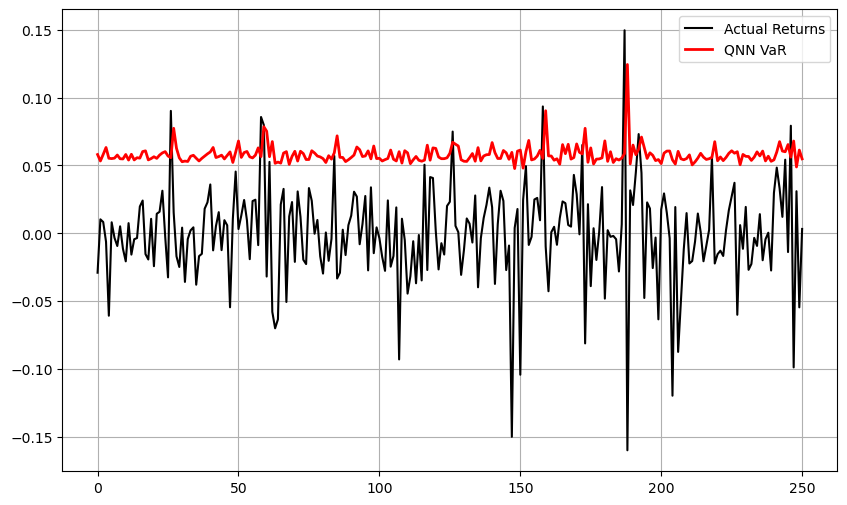

In [19]:
t = -y_true
p = -np.array(y_pred)
plt.figure(figsize=(10,6))
plt.plot(range(len(y_true)) , t , 
            color='k',
            label = "Actual Returns")
plt.plot(range(len(y_pred)) , p , 
         color='r', 
         linewidth=2,
         label = "QNN VaR")

plt.legend()
plt.grid()
plt.show()

In [ ]:
def quantile_loss(q):
    def ql(y_true , y_pred): 
        e = y_true - y_pred
        #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
        loss = K.mean(K.maximum(q*e , (q-1)*e)) 
        return loss

    return ql

q = 0.05
T = len(df_train)
N = len(df)
results = []

y_pred = []
for t in range(T+166, N):
    y_prediction = []
    for nseed in range(1, 101):
        seed = nseed
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)

        nn_reg = keras.Sequential()
        nn_reg.add(keras.layers.Dropout(0.1))
        nn_reg.add(keras.layers.Dense(2, input_dim = 5, activation='sigmoid', kernel_regularizer=l2(0)))
        nn_reg.add(keras.layers.Dense(1, activation='linear'))
        #nn_reg.summary()
                                        
        # compile neural network
        nn_reg.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.01), loss=quantile_loss(q))   
                                          
        x_t = df.iloc[t-T:t, list(range(1, 2)) + list(range(4, 7)) + list(range(7, 8))].to_numpy()
        y_t = df.iloc[t-T:t, 0].to_numpy()                         
        model = nn_reg.fit(x_t, y_t, epochs = 100, verbose = 0)
        x_test = df.iloc[t, list(range(1, 2)) + list(range(4, 7)) + list(range(7, 8))].to_numpy()
        x_test = np.expand_dims(x_test, axis=0)
        y_test = df.iloc[t, 0]

        predictions = nn_reg.predict(x_test)   
        y_prediction.append(predictions)               

    y_pred.append(np.mean(y_prediction))  

In [ ]:
y_pred3 = pd.DataFrame(y_pred, columns = ['predictions'])
y_pred3.to_csv('y_pred3.csv', index=True)

## Try different DNN architecture (WITH VOLUME)

In [ ]:
print(top_price.shape)
print(top_ret.shape)

(754,)
(753,)


In [14]:
ticker = ['TSLA']
start_date = stock_start_date
end_date = stock_end_date

price = yf.download(ticker,
                        start = start_date,
                        end = end_date)

volume = price['Volume']

[*********************100%***********************]  1 of 1 completed


In [15]:
top_price

Date
2016-01-04    14.894000
2016-01-05    14.895333
2016-01-06    14.602667
2016-01-07    14.376667
2016-01-08    14.066667
                ...    
2018-12-24    19.692667
2018-12-26    21.739332
2018-12-27    21.075333
2018-12-28    22.257999
2018-12-31    22.186666
Name: Adj Close, Length: 754, dtype: float64

In [16]:
volume.columns = ['TSLA_Vol']
merged_df = pd.concat([top_ret, volume], axis=1)
merged_df.dropna(axis = 0, inplace = True)
merged_df['Volume'] = (merged_df['Volume'] - np.mean(merged_df['Volume']))/np.std(merged_df['Volume'])
merged_df


,Adj Close,Volume
Date,,
2016-01-05,0.000090,-0.841534
2016-01-06,-0.019844,-0.691856
2016-01-07,-0.015598,-0.748664
2016-01-08,-0.021799,-0.730015
2016-01-11,-0.015041,-0.612935
...,...,...
2018-12-24,-0.079305,-0.241834
2018-12-26,0.098877,0.416014
2018-12-27,-0.031020,0.520130


In [24]:
# define a function to train VaRNN
def train_VaRNN(ret, quantile):
    # define quantile regression function
    def quantile_loss(q):
        def ql(y_true , y_pred): 
            e = y_true - y_pred
            #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
            loss = K.mean(K.maximum(q*e , (q-1)*e)) 
            return loss

        return ql
    
    T = 252*2
    num_return = len(ret)
    #num_asset = len(ret.columns)
    num_asset = 1
    investment_money = 100*num_asset
    VaR_NN = np.zeros(num_return - T)
    actual_ret = np.zeros(num_return - T)
    
    # build neural network 
    nn_reg = keras.Sequential()
    nn_reg.add(keras.layers.Dense(10, 
                                  input_dim = num_asset * 2,
                                  activation='relu')) 
    nn_reg.add(keras.layers.Dense(1, activation='linear')) 
    #nn_reg.summary()
    
    # compile neural network
    nn_reg.compile(optimizer = keras.optimizers.Adam(),
                   loss=quantile_loss(quantile))
    
    
    # train neural network
    for t in range(T, num_return):

        w = 1/num_asset
        
        scenario_port_ret_t = ret.iloc[t-T:t, :1] * w
        #scenario_port_ret_t = scenario_port_ret_t.sum(axis = 1)
        
        x_t = ret.iloc[t-T:t-1, :].to_numpy()
        y_t = scenario_port_ret_t.iloc[1:T].to_numpy()
        
        nn_reg.fit(x_t, 
                   y_t,
                   epochs = 50,
                   verbose = 0)
        
        ret_t = ret.iloc[t-1, :].to_numpy()
        ret_t = ret_t.reshape(1, -1)
        
        VaR_NN[t-T] = investment_money*nn_reg.predict(ret_t)
        #actual_ret[t-T] = investment_money*((ret.iloc[t,:10] * w).sum())
        actual_ret[t-T] = investment_money*(ret.iloc[t,:1] * w)
        
    return VaR_NN, actual_ret

In [28]:
VaR_NN_top, actual_ret_top = train_VaRNN(merged_df, VaR_q)

1/1 [==============================] - 0s 22ms/step


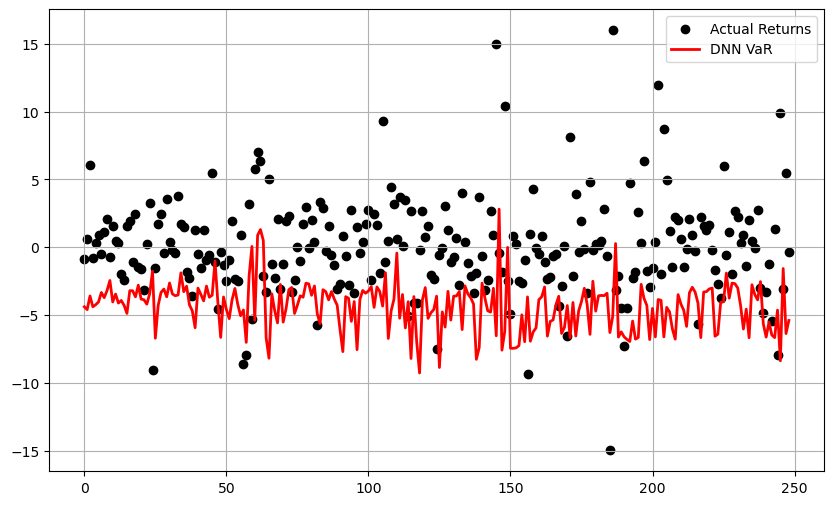

In [29]:
plt.figure(figsize=(10,6))
plt.scatter(range(len(actual_ret_top)) , actual_ret_top , 
            color='k',
            label = "Actual Returns")

plt.plot(range(len(VaR_NN_top)) , VaR_NN_top , 
         color='r',
         linewidth=2,
         label = "DNN VaR")

plt.legend()
plt.grid()
plt.show()

In [30]:
np.mean(actual_ret_top < VaR_NN_top)

0.10040160642570281

In [25]:
# define a function to train VaRNN
def train_VaRNN2(ret, quantile):
    # define quantile regression function
    def quantile_loss(q):
        def ql(y_true , y_pred): 
            e = y_true - y_pred
            #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
            loss = K.mean(K.maximum(q*e , (q-1)*e)) 
            return loss

        return ql
    
    T = 252*2
    num_return = len(ret)
    #num_asset = len(ret.columns)
    num_asset = 1
    investment_money = 100*num_asset
    VaR_NN = np.zeros(num_return - T)
    actual_ret = np.zeros(num_return - T)
    
    # build neural network 
    nn_reg = keras.Sequential()
    nn_reg.add(keras.layers.Dense(10, 
                                  input_dim = num_asset * 2,
                                  activation='relu'))
    nn_reg.add(keras.layers.Dense(10, 
                                  activation='relu'))  
    nn_reg.add(keras.layers.Dense(1, activation='linear')) 
    #nn_reg.summary()
    
    # compile neural network
    nn_reg.compile(optimizer = keras.optimizers.Adam(),
                   loss=quantile_loss(quantile))
    
    
    # train neural network
    for t in range(T, num_return):

        w = 1/num_asset
        
        scenario_port_ret_t = ret.iloc[t-T:t, :1] * w
        #scenario_port_ret_t = scenario_port_ret_t.sum(axis = 1)
        
        x_t = ret.iloc[t-T:t-1, :].to_numpy()
        y_t = scenario_port_ret_t.iloc[1:T].to_numpy()
        
        nn_reg.fit(x_t, 
                   y_t,
                   epochs = 50,
                   verbose = 0)
        
        ret_t = ret.iloc[t-1, :].to_numpy()
        ret_t = ret_t.reshape(1, -1)
        
        VaR_NN[t-T] = investment_money*nn_reg.predict(ret_t)
        #actual_ret[t-T] = investment_money*((ret.iloc[t,:10] * w).sum())
        actual_ret[t-T] = investment_money*(ret.iloc[t,:1] * w)
        
    return VaR_NN, actual_ret

In [26]:
VaR_NN_top, actual_ret_top = train_VaRNN2(merged_df, VaR_q)

1/1 [==============================] - 0s 45ms/step


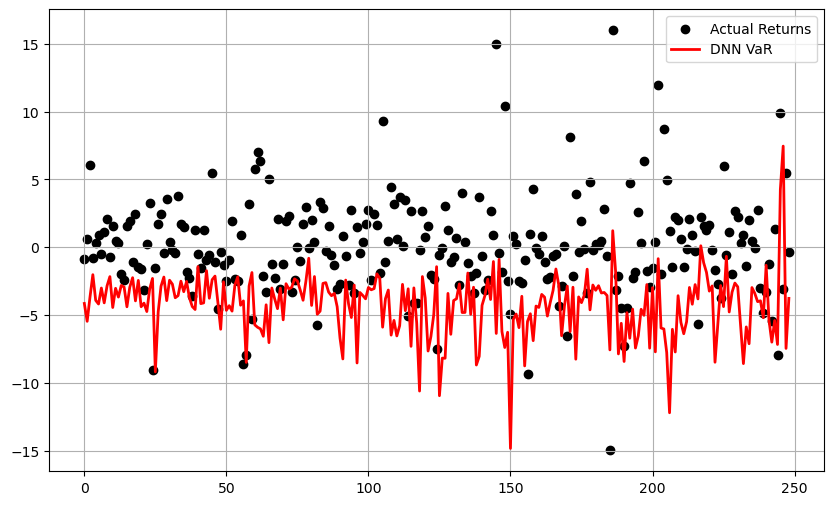

In [27]:
plt.figure(figsize=(10,6))
plt.scatter(range(len(actual_ret_top)) , actual_ret_top , 
            color='k',
            label = "Actual Returns")

plt.plot(range(len(actual_ret_top)) , VaR_NN_top , 
         color='r',
         linewidth=2,
         label = "DNN VaR")

plt.legend()
plt.grid()
plt.show()

In [28]:
np.mean(actual_ret_top < VaR_NN_top)

0.10843373493975904

In [198]:
# define a function to train VaRNN
def train_VaRNN3(ret, quantile):
    # define quantile regression function
    def quantile_loss(q):
        def ql(y_true , y_pred): 
            e = y_true - y_pred
            #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
            loss = K.mean(K.maximum(q*e , (q-1)*e)) 
            return loss

        return ql
    
    T = 252*2
    num_return = len(ret)
    #num_asset = len(ret.columns)
    num_asset = 1
    investment_money = 100*num_asset
    VaR_NN = np.zeros(num_return - T)
    actual_ret = np.zeros(num_return - T)
    
    # build neural network 
    nn_reg = keras.Sequential()
    nn_reg.add(keras.layers.Dense(16, 
                                  input_dim = num_asset * 2,
                                  activation='relu'))
    nn_reg.add(keras.layers.Dense(16, 
                                  activation='relu'))  
    nn_reg.add(keras.layers.Dense(1, activation='linear')) 
    #nn_reg.summary()
    
    # compile neural network
    nn_reg.compile(optimizer = keras.optimizers.Adam(),
                   loss=quantile_loss(quantile))
    
    
    # train neural network
    for t in range(T, num_return):

        w = 1/num_asset
        
        scenario_port_ret_t = ret.iloc[t-T:t, :1] * w
        #scenario_port_ret_t = scenario_port_ret_t.sum(axis = 1)
        
        x_t = ret.iloc[t-T:t-1, :].to_numpy()
        y_t = scenario_port_ret_t.iloc[1:T].to_numpy()
        
        nn_reg.fit(x_t, 
                   y_t,
                   epochs = 50,
                   verbose = 0)
        
        ret_t = ret.iloc[t-1, :].to_numpy()
        ret_t = ret_t.reshape(1, -1)
        
        VaR_NN[t-T] = investment_money*nn_reg.predict(ret_t)
        #actual_ret[t-T] = investment_money*((ret.iloc[t,:10] * w).sum())
        actual_ret[t-T] = investment_money*(ret.iloc[t,:1] * w)
        
    return VaR_NN, actual_ret


In [199]:
VaR_NN_top, actual_ret_top = train_VaRNN3(merged_df, VaR_q)

1/1 [==============================] - 0s 16ms/step


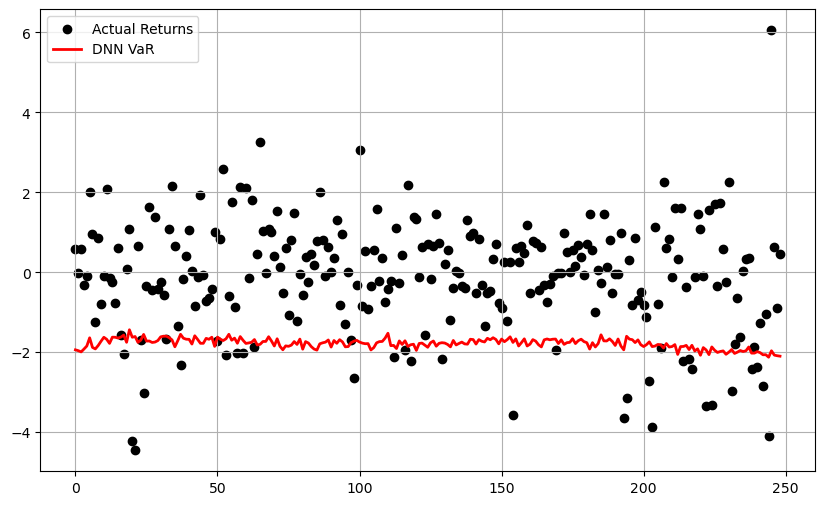

In [200]:
plt.figure(figsize=(10,6))
plt.scatter(range(len(actual_ret_top)) , actual_ret_top , 
            color='k',
            label = "Actual Returns")

plt.plot(range(len(VaR_NN_top)) , VaR_NN_top , 
         color='r',
         linewidth=2,
         label = "DNN VaR")

plt.legend()
plt.grid()
plt.show()

In [201]:
np.mean(actual_ret_top < VaR_NN_top)

0.13253012048192772

In [205]:
# define a function to train VaRNN
def train_VaRNN4(ret, quantile):
    # define quantile regression function
    def quantile_loss(q):
        def ql(y_true , y_pred): 
            e = y_true - y_pred
            #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
            loss = K.mean(K.maximum(q*e , (q-1)*e)) 
            return loss

        return ql
    
    T = 252*2
    num_return = len(ret)
    #num_asset = len(ret.columns)
    num_asset = 1
    investment_money = 100*num_asset
    VaR_NN = np.zeros(num_return - T)
    actual_ret = np.zeros(num_return - T)
    
    # build neural network 
    nn_reg = keras.Sequential()
    nn_reg.add(keras.layers.Dense(10, 
                                  input_dim = num_asset * 2,
                                  activation='relu'))
    nn_reg.add(keras.layers.Dense(10, 
                                  activation='relu'))  
    nn_reg.add(keras.layers.Dense(10, 
                                  activation='relu'))  
    nn_reg.add(keras.layers.Dense(1, activation='linear')) 
    #nn_reg.summary()
    
    # compile neural network
    nn_reg.compile(optimizer = keras.optimizers.Adam(),
                   loss=quantile_loss(quantile))
    
    
    # train neural network
    for t in range(T, num_return):

        w = 1/num_asset
        
        scenario_port_ret_t = ret.iloc[t-T:t, :1] * w
        #scenario_port_ret_t = scenario_port_ret_t.sum(axis = 1)
        
        x_t = ret.iloc[t-T:t-1, :].to_numpy()
        y_t = scenario_port_ret_t.iloc[1:T].to_numpy()
        
        nn_reg.fit(x_t, 
                   y_t,
                   epochs = 50,
                   verbose = 0)
        
        ret_t = ret.iloc[t-1, :].to_numpy()
        ret_t = ret_t.reshape(1, -1)
        
        VaR_NN[t-T] = investment_money*nn_reg.predict(ret_t)
        #actual_ret[t-T] = investment_money*((ret.iloc[t,:10] * w).sum())
        actual_ret[t-T] = investment_money*(ret.iloc[t,:1] * w)
        
    return VaR_NN, actual_ret

In [206]:
VaR_NN_top, actual_ret_top = train_VaRNN4(merged_df, VaR_q)

1/1 [==============================] - 0s 17ms/step


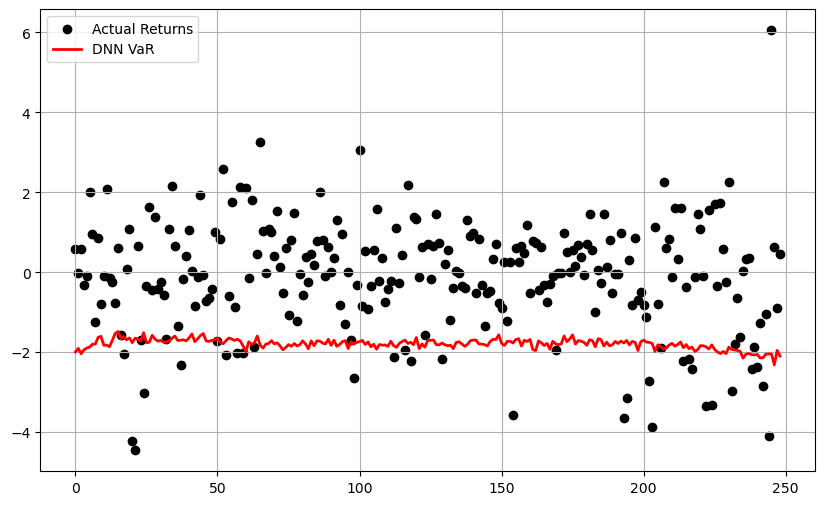

In [207]:
plt.figure(figsize=(10,6))
plt.scatter(range(len(actual_ret_top)) , actual_ret_top , 
            color='k',
            label = "Actual Returns")

plt.plot(range(len(VaR_NN_top)) , VaR_NN_top , 
         color='r',
         linewidth=2,
         label = "DNN VaR")

plt.legend()
plt.grid()
plt.show()

In [208]:
np.mean(actual_ret_top < VaR_NN_top)

0.1285140562248996

In [212]:
# define a function to train VaRNN
def train_VaRNN5(ret, quantile):
    # define quantile regression function
    def quantile_loss(q):
        def ql(y_true , y_pred): 
            e = y_true - y_pred
            #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
            loss = K.mean(K.maximum(q*e , (q-1)*e)) 
            return loss

        return ql
    
    T = 252*2
    num_return = len(ret)
    #num_asset = len(ret.columns)
    num_asset = 1
    investment_money = 100*num_asset
    VaR_NN = np.zeros(num_return - T)
    actual_ret = np.zeros(num_return - T)
    
    # build neural network 
    nn_reg = keras.Sequential()
    nn_reg.add(keras.layers.Dense(16, 
                                  input_dim = num_asset * 2,
                                  activation='relu'))
    nn_reg.add(keras.layers.Dense(16, 
                                  activation='relu'))  
    nn_reg.add(keras.layers.Dense(16, 
                                  activation='relu'))  
    nn_reg.add(keras.layers.Dense(1, activation='linear')) 
    #nn_reg.summary()
    
    # compile neural network
    nn_reg.compile(optimizer = keras.optimizers.Adam(),
                   loss=quantile_loss(quantile))
    
    
    # train neural network
    for t in range(T, num_return):

        w = 1/num_asset
        
        scenario_port_ret_t = ret.iloc[t-T:t, :1] * w
        #scenario_port_ret_t = scenario_port_ret_t.sum(axis = 1)
        
        x_t = ret.iloc[t-T:t-1, :].to_numpy()
        y_t = scenario_port_ret_t.iloc[1:T].to_numpy()
        
        nn_reg.fit(x_t, 
                   y_t,
                   epochs = 50,
                   verbose = 0)
        
        ret_t = ret.iloc[t-1, :].to_numpy()
        ret_t = ret_t.reshape(1, -1)
        
        VaR_NN[t-T] = investment_money*nn_reg.predict(ret_t)
        #actual_ret[t-T] = investment_money*((ret.iloc[t,:10] * w).sum())
        actual_ret[t-T] = investment_money*(ret.iloc[t,:1] * w)
        
    return VaR_NN, actual_ret

In [214]:
VaR_NN_top, actual_ret_top = train_VaRNN5(merged_df, VaR_q)

1/1 [==============================] - 0s 17ms/step


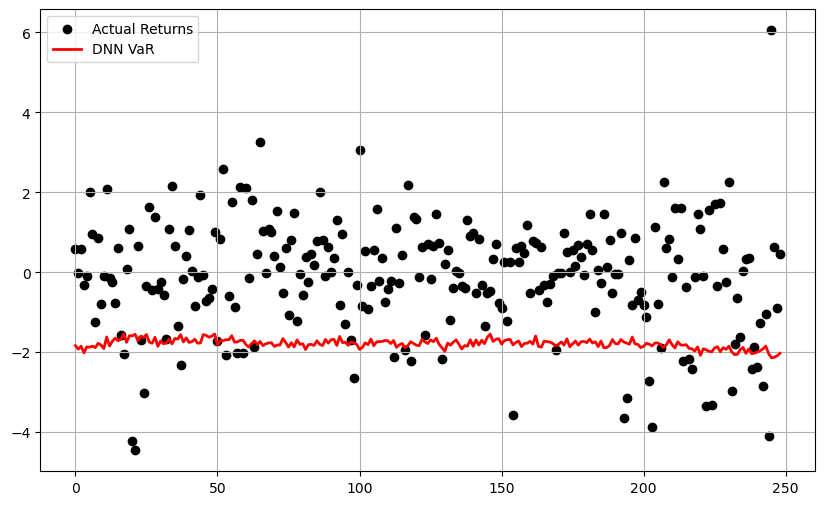

In [215]:
plt.figure(figsize=(10,6))
plt.scatter(range(len(actual_ret_top)) , actual_ret_top , 
            color='k',
            label = "Actual Returns")

plt.plot(range(len(VaR_NN_top)) , VaR_NN_top , 
         color='r',
         linewidth=2,
         label = "DNN VaR")

plt.legend()
plt.grid()
plt.show()

In [216]:
np.mean(actual_ret_top < VaR_NN_top)

0.1285140562248996

In [217]:
# define a function to train VaRNN
def train_VaRNN6(ret, quantile):
    # define quantile regression function
    def quantile_loss(q):
        def ql(y_true , y_pred): 
            e = y_true - y_pred
            #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
            loss = K.mean(K.maximum(q*e , (q-1)*e)) 
            return loss

        return ql
    
    T = 252*2
    num_return = len(ret)
    #num_asset = len(ret.columns)
    num_asset = 1
    investment_money = 100*num_asset
    VaR_NN = np.zeros(num_return - T)
    actual_ret = np.zeros(num_return - T)
    
    # build neural network 
    nn_reg = keras.Sequential()
    nn_reg.add(keras.layers.Dense(16, 
                                  input_dim = num_asset * 2,
                                  activation='relu'))
    nn_reg.add(keras.layers.Dense(16, 
                                  activation='sigmoid'))  
    nn_reg.add(keras.layers.Dense(16, 
                                  activation='relu'))  
    nn_reg.add(keras.layers.Dense(1, activation='linear')) 
    #nn_reg.summary()
    
    # compile neural network
    nn_reg.compile(optimizer = keras.optimizers.Adam(),
                   loss=quantile_loss(quantile))
    
    
    # train neural network
    for t in range(T, num_return):

        w = 1/num_asset
        
        scenario_port_ret_t = ret.iloc[t-T:t, :1] * w
        #scenario_port_ret_t = scenario_port_ret_t.sum(axis = 1)
        
        x_t = ret.iloc[t-T:t-1, :].to_numpy()
        y_t = scenario_port_ret_t.iloc[1:T].to_numpy()
        
        nn_reg.fit(x_t, 
                   y_t,
                   epochs = 50,
                   verbose = 0)
        
        ret_t = ret.iloc[t-1, :].to_numpy()
        ret_t = ret_t.reshape(1, -1)
        
        VaR_NN[t-T] = investment_money*nn_reg.predict(ret_t)
        #actual_ret[t-T] = investment_money*((ret.iloc[t,:10] * w).sum())
        actual_ret[t-T] = investment_money*(ret.iloc[t,:1] * w)
        
    return VaR_NN, actual_ret

In [219]:
VaR_NN_top, actual_ret_top = train_VaRNN6(merged_df, VaR_q)

1/1 [==============================] - 0s 99ms/step


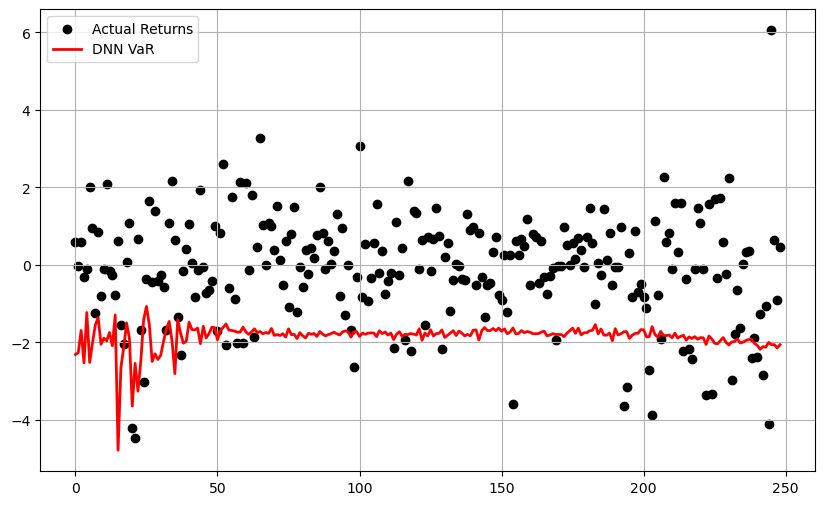

In [220]:
plt.figure(figsize=(10,6))
plt.scatter(range(len(actual_ret_top)) , actual_ret_top , 
            color='k',
            label = "Actual Returns")

plt.plot(range(len(VaR_NN_top)) , VaR_NN_top , 
         color='r',
         linewidth=2,
         label = "DNN VaR")

plt.legend()
plt.grid()
plt.show()

In [221]:
np.mean(actual_ret_top < VaR_NN_top)

0.12449799196787148

In [224]:
# define a function to train VaRNN
def train_VaRNN7(ret, quantile):
    # define quantile regression function
    def quantile_loss(q):
        def ql(y_true , y_pred): 
            e = y_true - y_pred
            #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
            loss = K.mean(K.maximum(q*e , (q-1)*e)) 
            return loss

        return ql
    
    T = 252*2
    num_return = len(ret)
    #num_asset = len(ret.columns)
    num_asset = 1
    investment_money = 100*num_asset
    VaR_NN = np.zeros(num_return - T)
    actual_ret = np.zeros(num_return - T)
    
    # build neural network 
    nn_reg = keras.Sequential()
    nn_reg.add(keras.layers.Dense(16, 
                                  input_dim = num_asset * 2,
                                  activation='sigmoid'))
    nn_reg.add(keras.layers.Dense(16, 
                                  activation='sigmoid'))  
    nn_reg.add(keras.layers.Dense(16, 
                                  activation='relu'))  
    nn_reg.add(keras.layers.Dense(1, activation='linear')) 
    #nn_reg.summary()
    
    # compile neural network
    nn_reg.compile(optimizer = keras.optimizers.Adam(),
                   loss=quantile_loss(quantile))
    
    
    # train neural network
    for t in range(T, num_return):

        w = 1/num_asset
        
        scenario_port_ret_t = ret.iloc[t-T:t, :1] * w
        #scenario_port_ret_t = scenario_port_ret_t.sum(axis = 1)
        
        x_t = ret.iloc[t-T:t-1, :].to_numpy()
        y_t = scenario_port_ret_t.iloc[1:T].to_numpy()
        
        nn_reg.fit(x_t, 
                   y_t,
                   epochs = 50,
                   verbose = 0)
        
        ret_t = ret.iloc[t-1, :].to_numpy()
        ret_t = ret_t.reshape(1, -1)
        
        VaR_NN[t-T] = investment_money*nn_reg.predict(ret_t)
        #actual_ret[t-T] = investment_money*((ret.iloc[t,:10] * w).sum())
        actual_ret[t-T] = investment_money*(ret.iloc[t,:1] * w)
        
    return VaR_NN, actual_ret

In [225]:
VaR_NN_top, actual_ret_top = train_VaRNN7(merged_df, VaR_q)

1/1 [==============================] - 0s 21ms/step


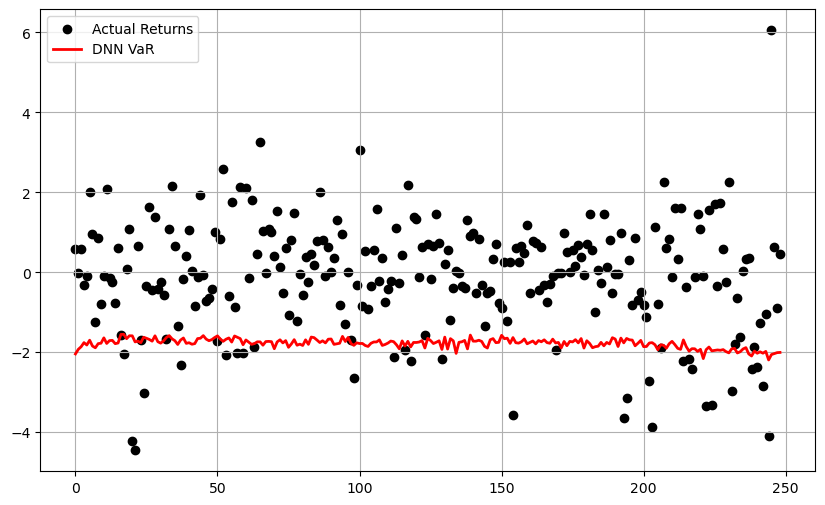

In [226]:
plt.figure(figsize=(10,6))
plt.scatter(range(len(actual_ret_top)) , actual_ret_top , 
            color='k',
            label = "Actual Returns")

plt.plot(range(len(VaR_NN_top)) , VaR_NN_top , 
         color='r',
         linewidth=2,
         label = "DNN VaR")

plt.legend()
plt.grid()
plt.show()

In [227]:
np.mean(actual_ret_top < VaR_NN_top)

0.13654618473895583

In [228]:
# define a function to train VaRNN
def train_VaRNN8(ret, quantile):
    # define quantile regression function
    def quantile_loss(q):
        def ql(y_true , y_pred): 
            e = y_true - y_pred
            #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
            loss = K.mean(K.maximum(q*e , (q-1)*e)) 
            return loss

        return ql
    
    T = 252*2
    num_return = len(ret)
    #num_asset = len(ret.columns)
    num_asset = 1
    investment_money = 100*num_asset
    VaR_NN = np.zeros(num_return - T)
    actual_ret = np.zeros(num_return - T)
    
    # build neural network 
    nn_reg = keras.Sequential()
    nn_reg.add(keras.layers.Dense(16, 
                                  input_dim = num_asset * 2,
                                  activation='relu'))
    nn_reg.add(keras.layers.Dense(16, 
                                  activation='sigmoid'))  
    nn_reg.add(keras.layers.Dense(16, 
                                  activation='sigmoid'))  
    nn_reg.add(keras.layers.Dense(1, activation='linear')) 
    #nn_reg.summary()
    
    # compile neural network
    nn_reg.compile(optimizer = keras.optimizers.Adam(),
                   loss=quantile_loss(quantile))
    
    
    # train neural network
    for t in range(T, num_return):

        w = 1/num_asset
        
        scenario_port_ret_t = ret.iloc[t-T:t, :1] * w
        #scenario_port_ret_t = scenario_port_ret_t.sum(axis = 1)
        
        x_t = ret.iloc[t-T:t-1, :].to_numpy()
        y_t = scenario_port_ret_t.iloc[1:T].to_numpy()
        
        nn_reg.fit(x_t, 
                   y_t,
                   epochs = 50,
                   verbose = 0)
        
        ret_t = ret.iloc[t-1, :].to_numpy()
        ret_t = ret_t.reshape(1, -1)
        
        VaR_NN[t-T] = investment_money*nn_reg.predict(ret_t)
        #actual_ret[t-T] = investment_money*((ret.iloc[t,:10] * w).sum())
        actual_ret[t-T] = investment_money*(ret.iloc[t,:1] * w)
        
    return VaR_NN, actual_ret

In [229]:
VaR_NN_top, actual_ret_top = train_VaRNN8(merged_df, VaR_q)

1/1 [==============================] - 0s 35ms/step


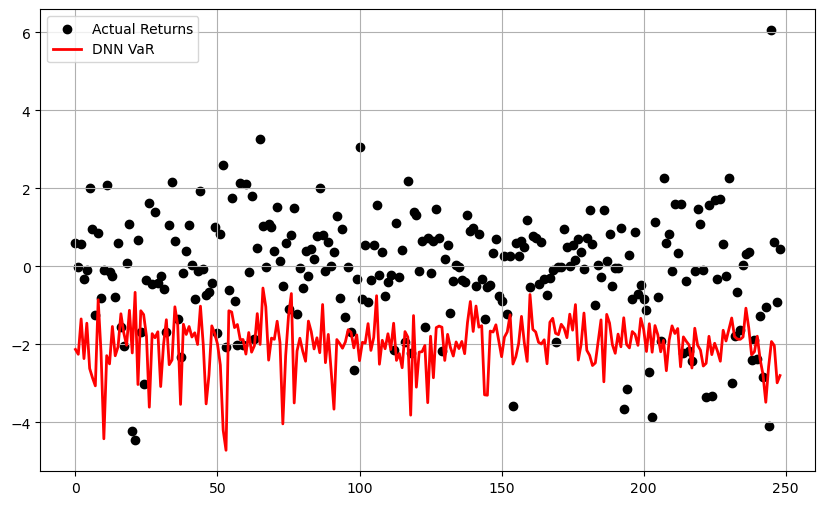

In [230]:
plt.figure(figsize=(10,6))
plt.scatter(range(len(actual_ret_top)) , actual_ret_top , 
            color='k',
            label = "Actual Returns")

plt.plot(range(len(VaR_NN_top)) , VaR_NN_top , 
         color='r',
         linewidth=2,
         label = "DNN VaR")

plt.legend()
plt.grid()
plt.show()

In [231]:
np.mean(actual_ret_top < VaR_NN_top)

0.11244979919678715

In [233]:
def train_VaRNN9(ret, quantile):
    # define quantile regression function
    def quantile_loss(q):
        def ql(y_true , y_pred): 
            e = y_true - y_pred
            #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
            loss = K.mean(K.maximum(q*e , (q-1)*e)) 
            return loss

        return ql
    
    T = 252*2
    num_return = len(ret)
    #num_asset = len(ret.columns)
    num_asset = 1
    investment_money = 100*num_asset
    VaR_NN = np.zeros(num_return - T)
    actual_ret = np.zeros(num_return - T)
    
    # build neural network 
    nn_reg = keras.Sequential()
    nn_reg.add(keras.layers.Dense(10, 
                                  input_dim = num_asset * 2,
                                  activation='relu'))
    nn_reg.add(keras.layers.Dense(16,
                                  activation='sigmoid'))
    nn_reg.add(keras.layers.Dense(16, 
                                  activation='sigmoid'))  
    nn_reg.add(keras.layers.Dense(16, 
                                  activation='sigmoid'))  
    nn_reg.add(keras.layers.Dense(1, activation='linear')) 
    #nn_reg.summary()
    
    # compile neural network
    nn_reg.compile(optimizer = keras.optimizers.Adam(),
                   loss=quantile_loss(quantile))
    
    
    # train neural network
    for t in range(T, num_return):

        w = 1/num_asset
        
        scenario_port_ret_t = ret.iloc[t-T:t, :1] * w
        #scenario_port_ret_t = scenario_port_ret_t.sum(axis = 1)
        
        x_t = ret.iloc[t-T:t-1, :].to_numpy()
        y_t = scenario_port_ret_t.iloc[1:T].to_numpy()
        
        nn_reg.fit(x_t, 
                   y_t,
                   epochs = 50,
                   verbose = 0)
        
        ret_t = ret.iloc[t-1, :].to_numpy()
        ret_t = ret_t.reshape(1, -1)
        
        VaR_NN[t-T] = investment_money*nn_reg.predict(ret_t)
        #actual_ret[t-T] = investment_money*((ret.iloc[t,:10] * w).sum())
        actual_ret[t-T] = investment_money*(ret.iloc[t,:1] * w)
        
    return VaR_NN, actual_ret

In [234]:
VaR_NN_top, actual_ret_top = train_VaRNN9(merged_df, VaR_q)

1/1 [==============================] - 0s 16ms/step


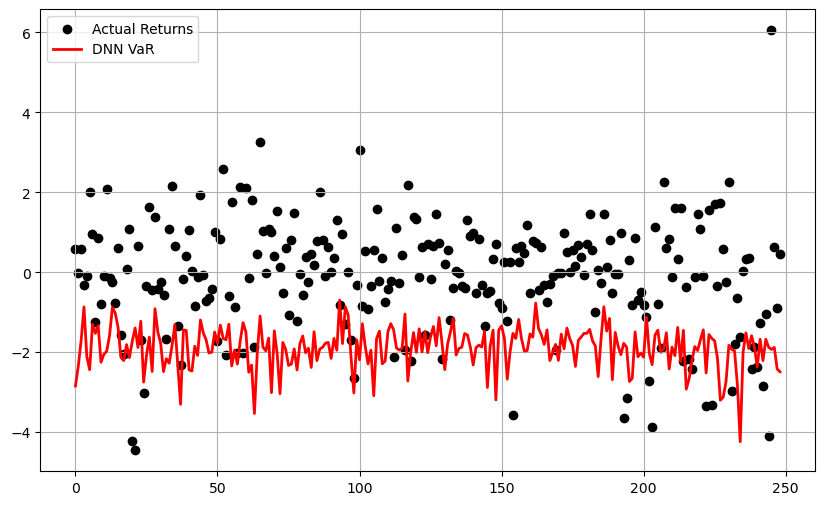

In [235]:
plt.figure(figsize=(10,6))
plt.scatter(range(len(actual_ret_top)) , actual_ret_top , 
            color='k',
            label = "Actual Returns")

plt.plot(range(len(VaR_NN_top)) , VaR_NN_top , 
         color='r',
         linewidth=2,
         label = "DNN VaR")

plt.legend()
plt.grid()
plt.show()

In [236]:
np.mean(actual_ret_top < VaR_NN_top)

0.11646586345381527

In [238]:
def train_VaRNN10(ret, quantile):
    # define quantile regression function
    def quantile_loss(q):
        def ql(y_true , y_pred): 
            e = y_true - y_pred
            #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
            loss = K.mean(K.maximum(q*e , (q-1)*e)) 
            return loss

        return ql
    
    T = 252*2
    num_return = len(ret)
    #num_asset = len(ret.columns)
    num_asset = 1
    investment_money = 100*num_asset
    VaR_NN = np.zeros(num_return - T)
    actual_ret = np.zeros(num_return - T)
    
    # build neural network 
    nn_reg = keras.Sequential()
    nn_reg.add(keras.layers.Dense(20, 
                                  input_dim = num_asset * 2,
                                  activation='relu'))
    nn_reg.add(keras.layers.Dense(16,
                                  activation='sigmoid'))
    nn_reg.add(keras.layers.Dense(16, 
                                  activation='sigmoid'))  
    nn_reg.add(keras.layers.Dense(16, 
                                  activation='sigmoid'))  
    nn_reg.add(keras.layers.Dense(1, activation='linear')) 
    #nn_reg.summary()
    
    # compile neural network
    nn_reg.compile(optimizer = keras.optimizers.Adam(),
                   loss=quantile_loss(quantile))
    
    
    # train neural network
    for t in range(T, num_return):

        w = 1/num_asset
        
        scenario_port_ret_t = ret.iloc[t-T:t, :1] * w
        #scenario_port_ret_t = scenario_port_ret_t.sum(axis = 1)
        
        x_t = ret.iloc[t-T:t-1, :].to_numpy()
        y_t = scenario_port_ret_t.iloc[1:T].to_numpy()
        
        nn_reg.fit(x_t, 
                   y_t,
                   epochs = 50,
                   verbose = 0)
        
        ret_t = ret.iloc[t-1, :].to_numpy()
        ret_t = ret_t.reshape(1, -1)
        
        VaR_NN[t-T] = investment_money*nn_reg.predict(ret_t)
        #actual_ret[t-T] = investment_money*((ret.iloc[t,:10] * w).sum())
        actual_ret[t-T] = investment_money*(ret.iloc[t,:1] * w)
        
    return VaR_NN, actual_ret

In [239]:
VaR_NN_top, actual_ret_top = train_VaRNN10(merged_df, VaR_q)

1/1 [==============================] - 0s 15ms/step


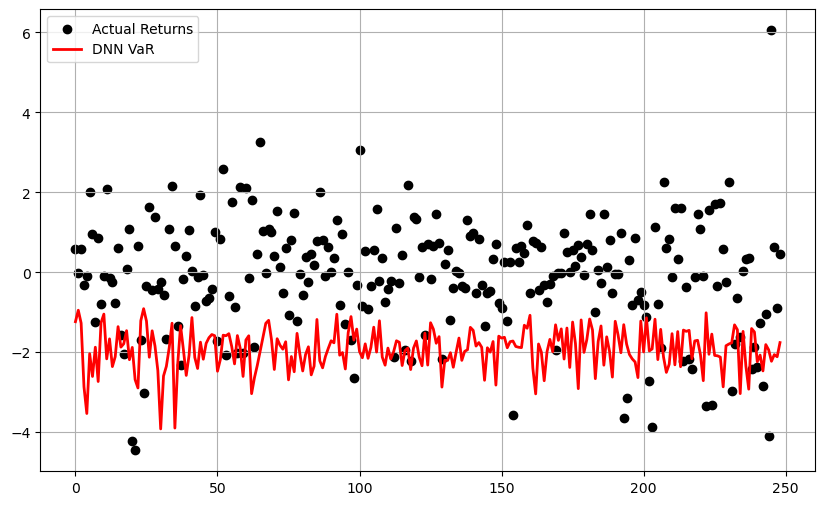

In [240]:
plt.figure(figsize=(10,6))
plt.scatter(range(len(actual_ret_top)) , actual_ret_top , 
            color='k',
            label = "Actual Returns")

plt.plot(range(len(VaR_NN_top)) , VaR_NN_top , 
         color='r',
         linewidth=2,
         label = "DNN VaR")

plt.legend()
plt.grid()
plt.show()

In [241]:
np.mean(actual_ret_top < VaR_NN_top)

0.12449799196787148

# Use LSTM

In [36]:
# define a function to train VaRLSTM
def train_VaRLSTM(ret, quantile, time_steps):
    # define quantile regression function
    def quantile_loss(q):
        def ql(y_true , y_pred): 
            e = y_true - y_pred
            #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
            loss = K.mean(K.maximum(q*e , (q-1)*e)) 
            return loss

        return ql
    
    
    # define a function to get x and y
    def reshape_xy(x, y, time_steps):
        # prepare y
        y_idx = np.arange(time_steps, len(y), time_steps)
        training_y = y[y_idx]

        # prepare x
        rows_x = len(training_y)
        training_x = x[range(time_steps*rows_x)]
        training_x = np.reshape(training_x, (rows_x, time_steps, -1))

        return training_x, training_y
    
    
    T = 252*3
    num_return = len(ret)
    num_asset = len(ret.columns)
    investment_money = 100*num_asset
    VaR_LSTM = np.zeros(num_return - T)
    
    # build a neural network
    HIDDEN = 16
    LSTM = keras.Sequential()
    LSTM.add(keras.layers.Input(shape=(time_steps, num_asset))) #shape = (time_steps,features)
    LSTM.add(keras.layers.LSTM(HIDDEN, return_sequences=True, activation='relu'))
    # add return_sequences=True to all LSTM layers except the last one to allow for stacking
    LSTM.add(keras.layers.LSTM(HIDDEN, activation='relu'))
    LSTM.add(keras.layers.Dense(1, activation='linear')) #1 output y

    #LSTM.summary()
    
    # compile neural network
    LSTM.compile(optimizer = keras.optimizers.Adam(),
                 loss=quantile_loss(quantile))
    
    
    # train neural network
    for t in range(T, num_return):
                    
        w = 1/num_asset
        
        scenario_port_ret_t = ret.iloc[t-T:t, :]*w
        scenario_port_ret_t = scenario_port_ret_t.sum(axis = 1)
        
        x_t = ret.iloc[t-T: t-1, :].to_numpy()
        y_t = scenario_port_ret_t.iloc[1:T].to_numpy()
        
        # prepare for training x and training y
        training_x_t, training_y_t = reshape_xy(x_t, y_t, 2)
        
        LSTM.fit(training_x_t,
                 training_y_t,
                 epochs = 50,
                 verbose = 0)
        
        ret_t = ret.iloc[t-2: t, :].to_numpy()
        ret_t = ret_t.reshape(1, 2, -1)
        
        VaR_LSTM[t-T] = investment_money*LSTM.predict(ret_t)
        
    return VaR_LSTM
        
        

In [37]:
VaR_LSTM_top = train_VaRLSTM(top_ret, VaR_q, 2)


1/1 [==============================] - 0s 16ms/step


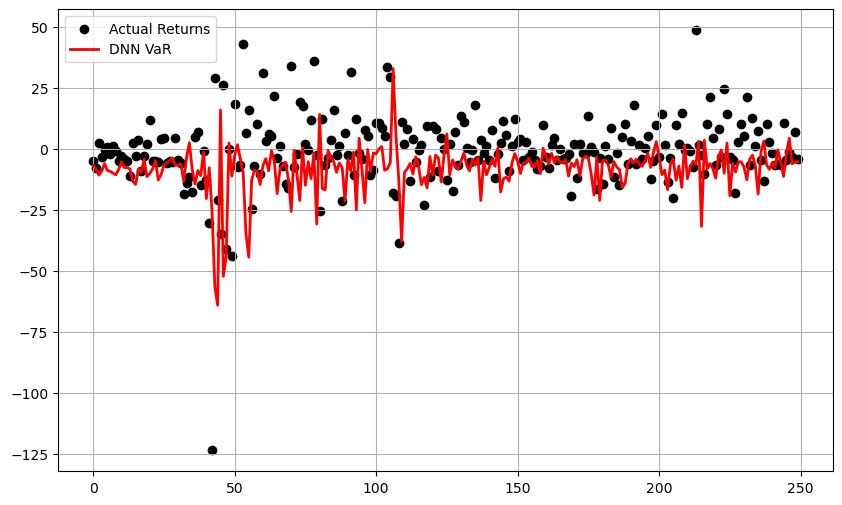

In [38]:
plt.figure(figsize=(10,6))
plt.scatter(range(len(actual_ret_top)) , actual_ret_top , 
            color='k',
            label = "Actual Returns")

plt.plot(range(len(VaR_LSTM_top)) , VaR_LSTM_top , 
         color='r',
         linewidth=2,
         label = "DNN VaR")

plt.legend()
plt.grid()
plt.show()

In [39]:
# Empirically we exceed our 95% VaR some of the time:
np.mean(actual_ret_top < VaR_LSTM_top)

0.276

In [222]:
# define a function to train VaRNN
def train_VaRNN7(ret, quantile):
    # define quantile regression function
    def quantile_loss(q):
        def ql(y_true , y_pred): 
            e = y_true - y_pred
            #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
            loss = K.mean(K.maximum(q*e , (q-1)*e)) 
            return loss

        return ql
    
    T = 252*2
    num_return = len(ret)
    #num_asset = len(ret.columns)
    num_asset = 1
    investment_money = 100*num_asset
    VaR_NN = np.zeros(num_return - T)
    actual_ret = np.zeros(num_return - T)
    
    # build neural network 
    nn_reg = keras.Sequential()
    nn_reg.add(keras.layers.Dense(16, 
                                  input_dim = num_asset * 2,
                                  activation='sigmoid'))
    nn_reg.add(keras.layers.Dense(16, 
                                  activation='sigmoid'))  
    nn_reg.add(keras.layers.Dense(16, 
                                  activation='relu'))  
    nn_reg.add(keras.layers.Dense(1, activation='linear')) 
    #nn_reg.summary()
    
    # compile neural network
    nn_reg.compile(optimizer = keras.optimizers.Adam(),
                   loss=quantile_loss(quantile))
    
    
    # train neural network
    for t in range(T, num_return):

        w = 1/num_asset
        
        scenario_port_ret_t = ret.iloc[t-T:t, :1] * w
        #scenario_port_ret_t = scenario_port_ret_t.sum(axis = 1)
        
        x_t = ret.iloc[t-T:t-1, :].to_numpy()
        y_t = scenario_port_ret_t.iloc[1:T].to_numpy()
        
        nn_reg.fit(x_t, 
                   y_t,
                   epochs = 50,
                   verbose = 0)
        
        ret_t = ret.iloc[t-1, :].to_numpy()
        ret_t = ret_t.reshape(1, -1)
        
        VaR_NN[t-T] = investment_money*nn_reg.predict(ret_t)
        #actual_ret[t-T] = investment_money*((ret.iloc[t,:10] * w).sum())
        actual_ret[t-T] = investment_money*(ret.iloc[t,:1] * w)
        
    return VaR_NN, actual_ret